# Setup

In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


import sys
import torch
import torch.utils.data as data
import torch.nn as nn
import easydict
import kornia as K


sys.path.append("..")
import utils
import mixmatch
import datasets
import transformations as custom_transforms


# Create SegmentationDatasetLabeled
labeled_dataset = datasets.SegmentationDatasetLabeled(
    dir_images="./my_dataset/images/",
    dir_masks="./my_dataset/masks/",
    #transform=transforms.ToTensor()
)

# Create DataLoader for SegmentationDatasetLabeled
batch_size = 3  # set your desired batch size
labeled_dataloader = data.DataLoader(
    labeled_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1  # set the number of worker processes for loading data
)

# Transforamtion
k1 = custom_transforms.GaussianNoiseChannelwise((0.01, 0.02, 0.025))
k2 = K.augmentation.RandomGaussianBlur((3,3),sigma=(5.,5.),p=1)
k3 = K.augmentation.RandomHorizontalFlip(p=1)
k4 = K.augmentation.RandomAffine([-45., 45.], [0., 0.15], [0.5, 1.5], [0., 0.15])

img_trans = nn.ModuleList([k1,k2,k3,k4])
mask_trans = nn.ModuleList([k2,k3,k4]) 
invert_trans  = nn.ModuleList([k3,k4])

transform = custom_transforms.MyAugmentation(img_trans,mask_trans,invert_trans)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Example
Example using averaging of the segmentation labels with `function average_segmentation_labels`:
```python
mixmatch.average_segmentation_labels(labels:torch.Tensor,keepshape:bool,eps:float)
```

Inputs w\ shape: torch.Size([2, 3, 3, 321, 481])


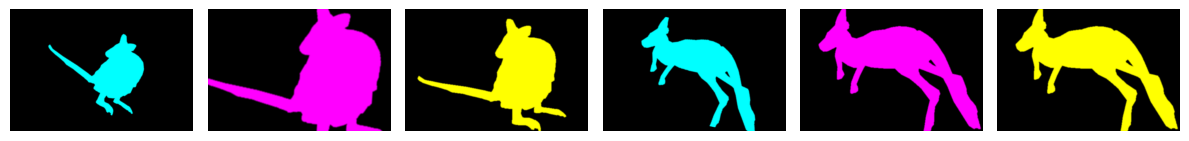

Averages w\ shape: torch.Size([2, 3, 321, 481])


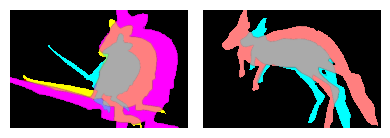

In [5]:
# Apply average segmentattion labels
for img,labels in labeled_dataloader:
    N,C,H,W = labels.shape
    
    # Duplicate labels
    L = 3
    labels = labels.repeat(1, L, 1, 1).reshape(N*L,C,H,W)
    
    # Apply transformation
    _,labels = transform(mask=labels)
    labels = labels.reshape(N,L,C,H,W)
    
    # Apply colors to distinguish between diferent labels
    labels[:,0] = utils.set_channel(labels[:,0],0.,0) # zero out red channel
    labels[:,1] = utils.set_channel(labels[:,1],0.,1)
    labels[:,2] = utils.set_channel(labels[:,2],0.,2)

    
    averages = mixmatch.average_labels(labels,keepshape=False,eps=0.5)
    
    # Report results
    print(f"Inputs w\ shape: {labels.shape}")
    utils.plot_batch(labels.reshape(N*L,C,H,W))
    print(f"Averages w\ shape: {averages.shape}")
    utils.plot_batch(averages.reshape(N,C,H,W))
    break


## Example
Inverse transform the labels, average them and once again transform them to initiale state

Inputs w\ shape: torch.Size([2, 3, 3, 321, 481])


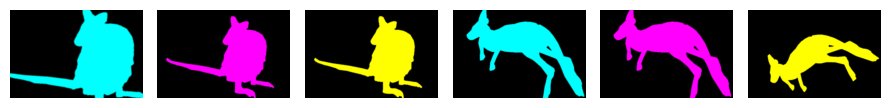

Inverese inputs w\ shape: torch.Size([2, 3, 3, 321, 481])


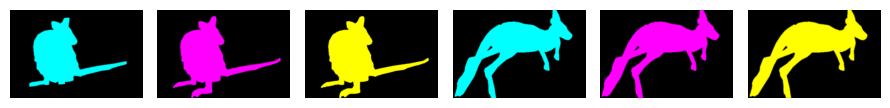

Inverese averages w\ shape: torch.Size([2, 3, 3, 321, 481])


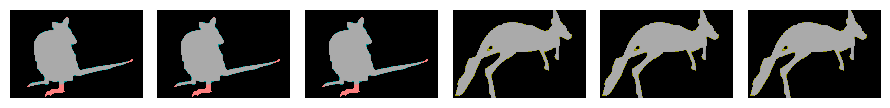

Averages w\ shape: torch.Size([2, 3, 3, 321, 481])


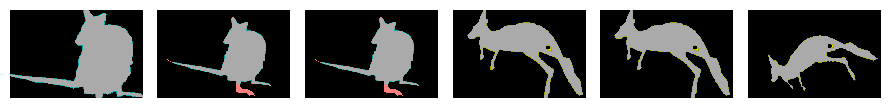

In [7]:

for img,labels in labeled_dataloader:
    N,C,H,W = labels.shape
    
    L = 3
    labels = labels.repeat(1, L, 1, 1).reshape(N*L,C,H,W)
    
    #Setup: apply transformation
    _,labels = transform(mask=labels)
    labels = labels.reshape(N,L,C,H,W)
    
    # Apply colors to distinguish between diferent labels
    labels[:,0] = utils.set_channel(labels[:,0],0.,0) # zero out red channel
    labels[:,1] = utils.set_channel(labels[:,1],0.,1)
    labels[:,2] = utils.set_channel(labels[:,2],0.,2)

    inverse_labels = transform.inverse_last_transformation(labels.reshape(N*L,C,H,W)).reshape(N,L,C,H,W)
    inverse_averages = mixmatch.average_labels(inverse_labels,keepshape=True,eps=0.5)

    

    _,averages = transform.apply_last_transformation(None,mask=inverse_averages.reshape(N*L,C,H,W))
    averages = averages.reshape(N,L,C,H,W)
    
    # Report results
    print(f"Inputs w\ shape: {labels.shape}")
    utils.plot_batch(labels.reshape(N*L,C,H,W),imgsize=(1.5,1.5))
    print(f"Inverese inputs w\ shape: {inverse_labels.shape}")
    utils.plot_batch(inverse_labels.reshape(N*L,C,H,W),imgsize=(1.5,1.5))
    print(f"Inverese averages w\ shape: {inverse_averages.shape}")
    utils.plot_batch(inverse_averages.reshape(N*L,C,H,W),imgsize=(1.5,1.5))
    print(f"Averages w\ shape: {averages.shape}")
    utils.plot_batch(averages.reshape(N*L,C,H,W),imgsize=(1.5,1.5))
    break


# Example
Example of computing `Mixmatch` for ground truth labels 

torch.Size([3, 3, 321, 481])
X_hat \w shape = torch.Size([1, 3, 321, 481])


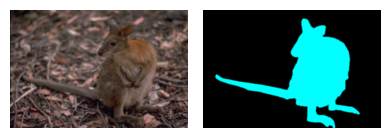

U_hat \w shape = torch.Size([2, 3, 321, 481])


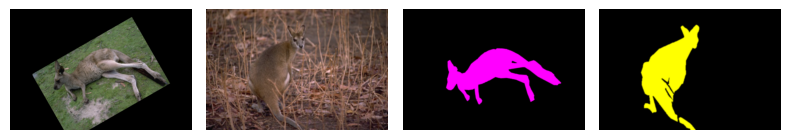

W_1 \w shape = torch.Size([1, 3, 321, 481])


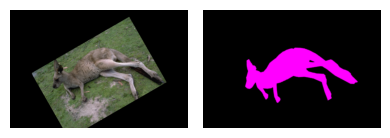

W_2 \w shape = torch.Size([2, 3, 321, 481])


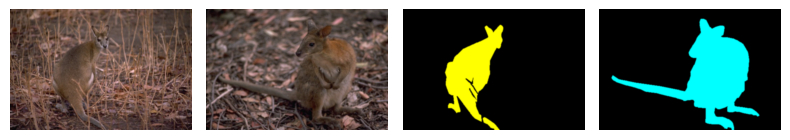

X_prime w\ shape: torch.Size([1, 3, 321, 481])


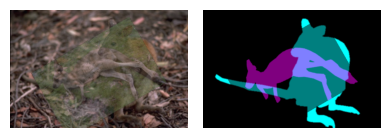

U_prime w\ shape: torch.Size([2, 3, 321, 481])


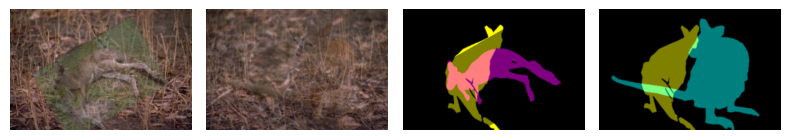

In [14]:
# Example on mixup process

# Apply average segmentattion labels
for img,labels in labeled_dataloader:
    N,C,H,W = labels.shape
    
    
    # Apply transformation
    aug_img,labels = transform(img,mask=labels)
    print(labels.shape)
    # Apply colors to distinguish between diferent labels
    labels[0:1] = utils.set_channel(labels[0:1],0.,0) # zero out red channel
    labels[1:2] = utils.set_channel(labels[1:2],0.,1)
    labels[2:3] = utils.set_channel(labels[2:3],0.,2)


    L = 1

    X_hat = (aug_img[0:L],labels[0:L])
    Y_hat = (aug_img[L:],labels[L:])
    print(f"X_hat \w shape = {X_hat[0].shape}")
    utils.plot_batch(torch.cat(X_hat,dim=0))
    print(f"U_hat \w shape = {Y_hat[0].shape}")
    utils.plot_batch(torch.cat(Y_hat,dim=0))


    W = mixmatch.concatenate_and_shuffle(X_hat,Y_hat)
    W_1 = (W[0][:L],W[1][:L])
    W_2 = (W[0][L:],W[1][L:])
    print(f"W_1 \w shape = {W_1[0].shape}")
    utils.plot_batch(torch.cat(W_1))
    print(f"W_2 \w shape = {W_2[0].shape}")
    utils.plot_batch(torch.cat(W_2))
    
    X_prime,x_lam = mixmatch.mixup(X_hat,W_1)
    Y_prime,y_lam = mixmatch.mixup(Y_hat,W_2)
    # Report results
    print(f"X_prime w\ shape: {X_prime[0].shape}")
    print(f"{x_lam=}")
    utils.plot_batch(torch.cat(X_prime,dim=0))
    print(f"Y_prime w\ shape: {Y_prime[0].shape}")
    print(f"{y_lam=}")
    utils.plot_batch(torch.cat(Y_prime,dim=0))
    break